In [1]:
# Dataframes
import pandas as pd

# Array
import numpy as np

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import preprocessing

# Performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc


# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay


# Neural network
import tensorflow as tf


# Seed
seed=123
tf.random.set_seed(seed)
np.random.seed(seed)


<AxesSubplot:>

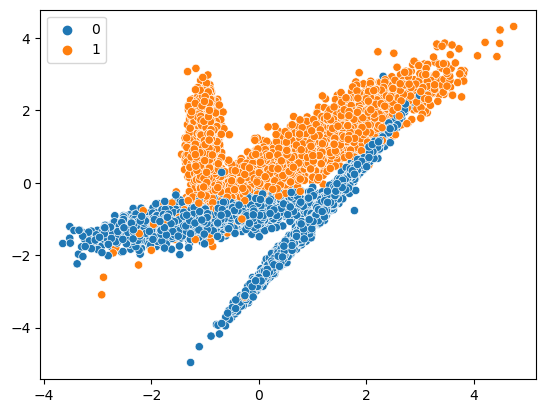

In [2]:
# Import dataset
X,y=make_classification(n_samples=10000,n_features=2,n_redundant=0,n_informative=2,n_clusters_per_class=2,random_state=seed)
df=pd.DataFrame(dict(x=X[:,0],y=X[:,1],label=y))
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y)

In [3]:
df.describe()

,x,y,label
count,10000.000000,10000.000000,10000.000000
mean,0.016285,0.003200,0.500400
std,1.267339,1.275156,0.500025
min,-3.652018,-4.963100,0.000000
25%,-1.002892,-1.010057,0.000000
50%,-0.153336,-0.067077,1.000000
75%,1.027410,1.024776,1.000000
max,4.748399,4.314188,1.000000


In [4]:
scaler = preprocessing.MinMaxScaler()
d=scaler.fit_transform(df)
scaled_df=pd.DataFrame(d,columns=df.columns)
scaled_df.head()

,x,y,label
0,0.614628,0.700765,1.0
1,0.592959,0.710371,1.0
2,0.574854,0.695166,1.0
3,0.313918,0.704785,1.0
4,0.341807,0.499906,1.0


In [5]:
scaled_df.describe()

,x,y,label
count,10000.000000,10000.000000,10000.000000
mean,0.436681,0.535318,0.500400
std,0.150866,0.137449,0.500025
min,0.000000,0.000000,0.000000
25%,0.315357,0.426099,0.000000
50%,0.416489,0.527743,1.000000
75%,0.557047,0.645434,1.000000
max,1.000000,1.000000,1.000000


In [6]:
# Split train and test
X=scaled_df[['x','y']]
y=scaled_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

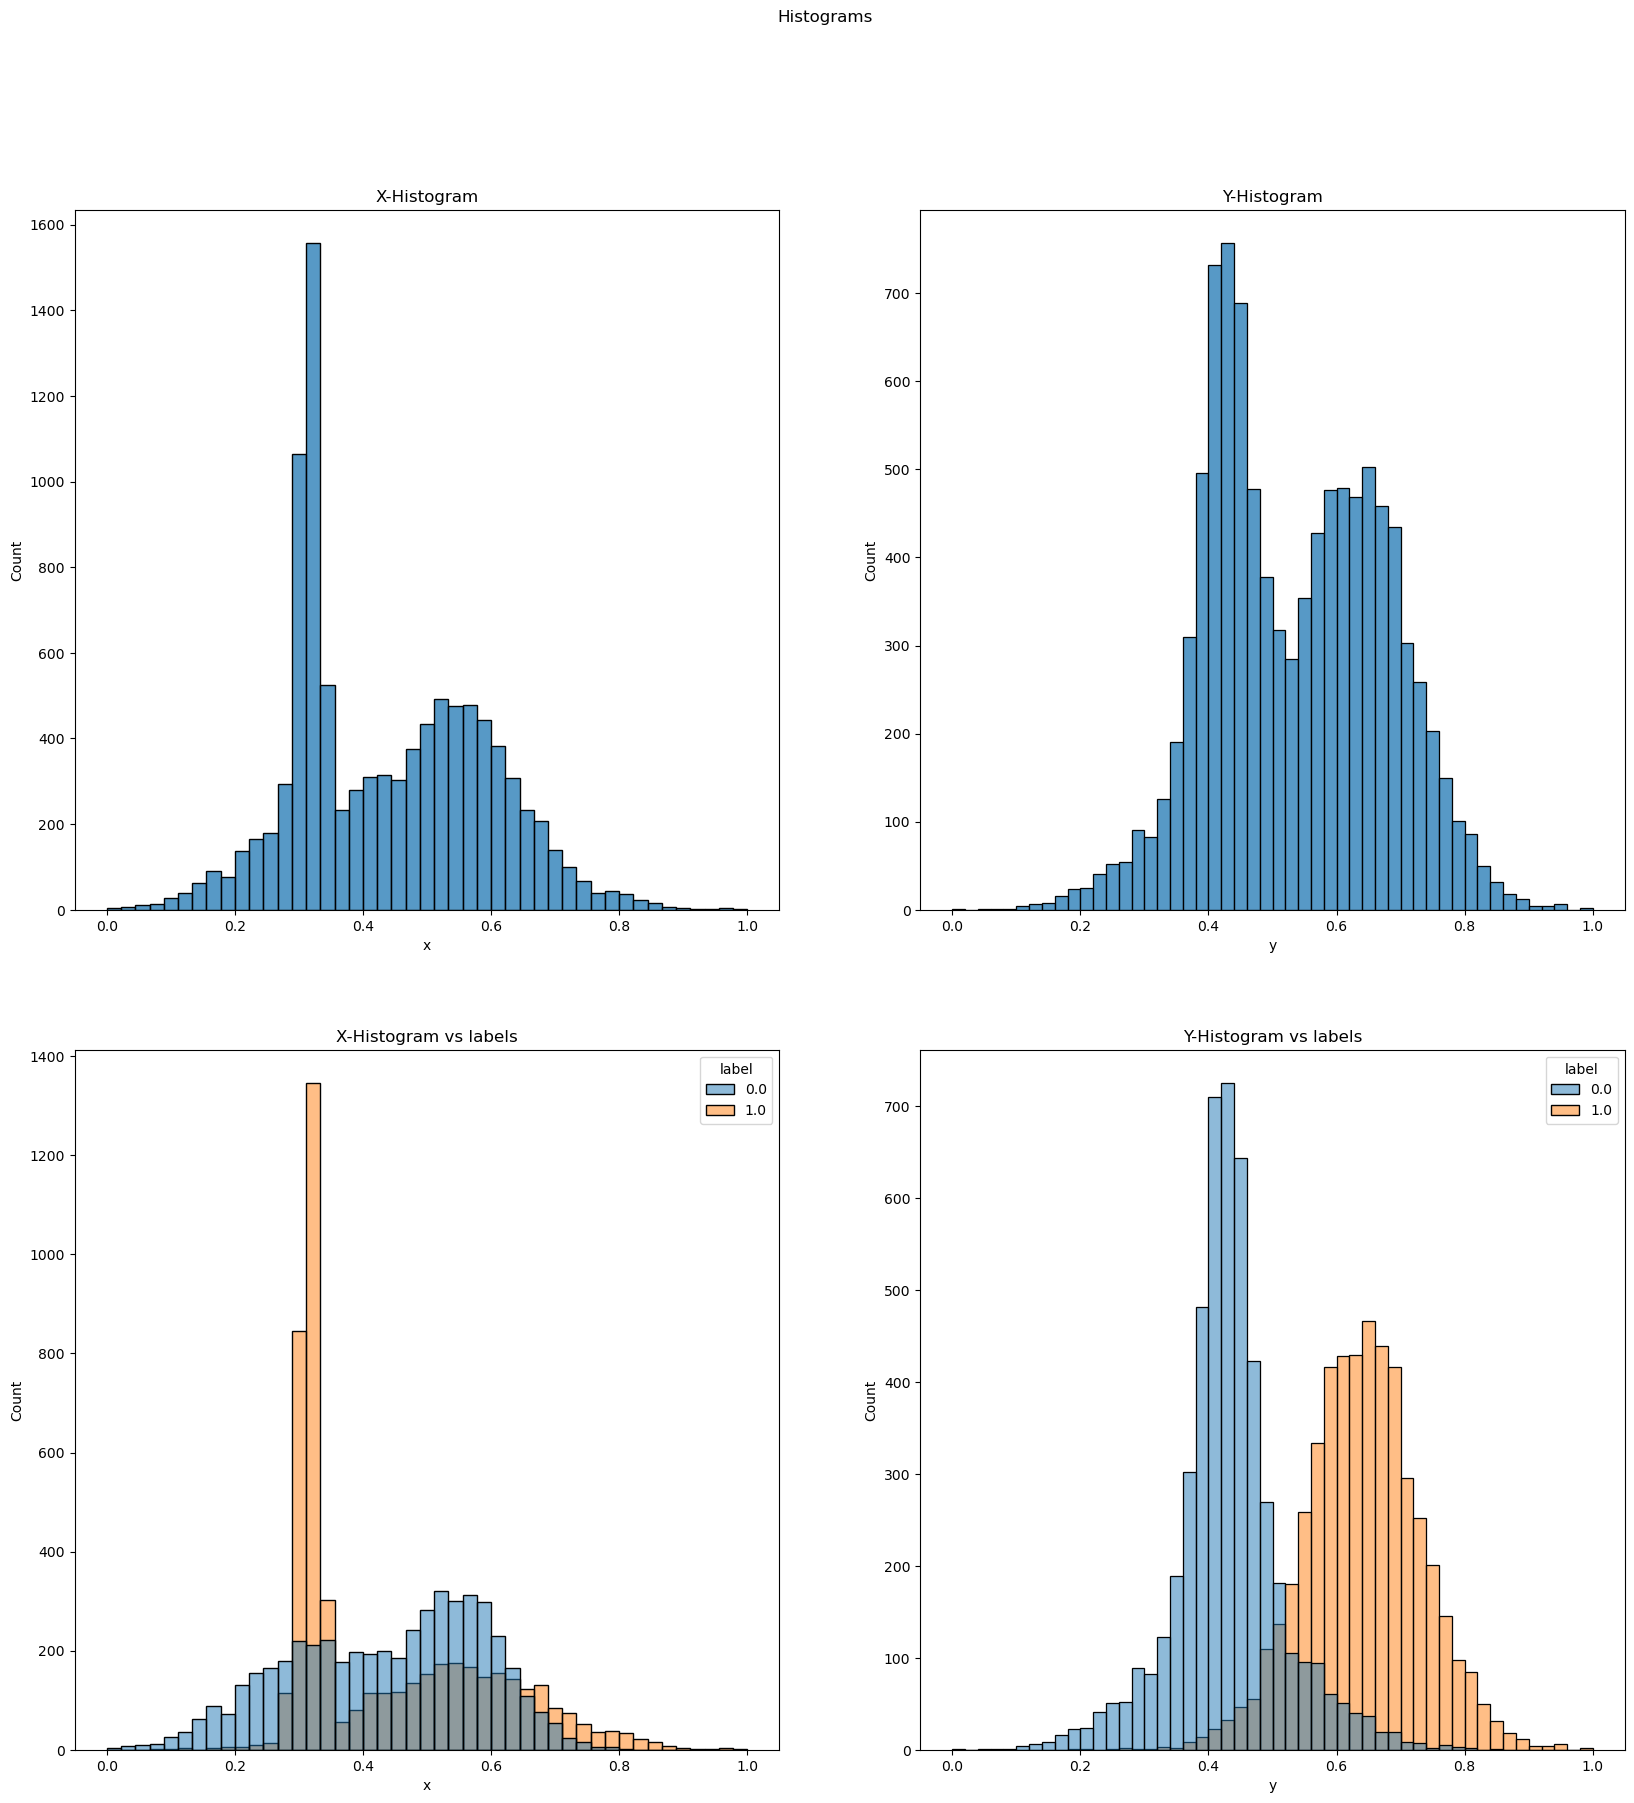

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20,20))
sns.histplot(ax=axes[0,0],data=scaled_df,x='x')
axes[0,0].set_title ("X-Histogram")

sns.histplot(ax=axes[0,1],data=scaled_df,x='y')
axes[0,1].set_title ("Y-Histogram")

sns.histplot(ax=axes[1,0],data=scaled_df,x='x',hue='label')
axes[1,0].set_title ("X-Histogram vs labels")

sns.histplot(ax=axes[1,1],data=scaled_df,x='y',hue='label')
axes[1,1].set_title ("Y-Histogram vs labels")

plt.suptitle ("Histograms")
plt.show()

In [53]:
# Build neural network
entrada = X_train.shape[1]# diferencia con R (la variable target ya está excluída)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=2, 
                                 activation='relu',
                                 #kernel_regularizer = tf.keras.regularizers.l2(1e-3), # se aplica parámetro de regularización 
                                 #kernel_initializer = "glorot_uniform",
                                 input_shape=(entrada,)))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Guardar el modelo
model_path='../modelos/inicial.h5'
model.save('inicial.h5')

In [25]:
history = model.fit(X_train, y_train, 
                     epochs=200, 
                     batch_size=128,
                     validation_split=0.2, 
                     verbose=0,
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)])



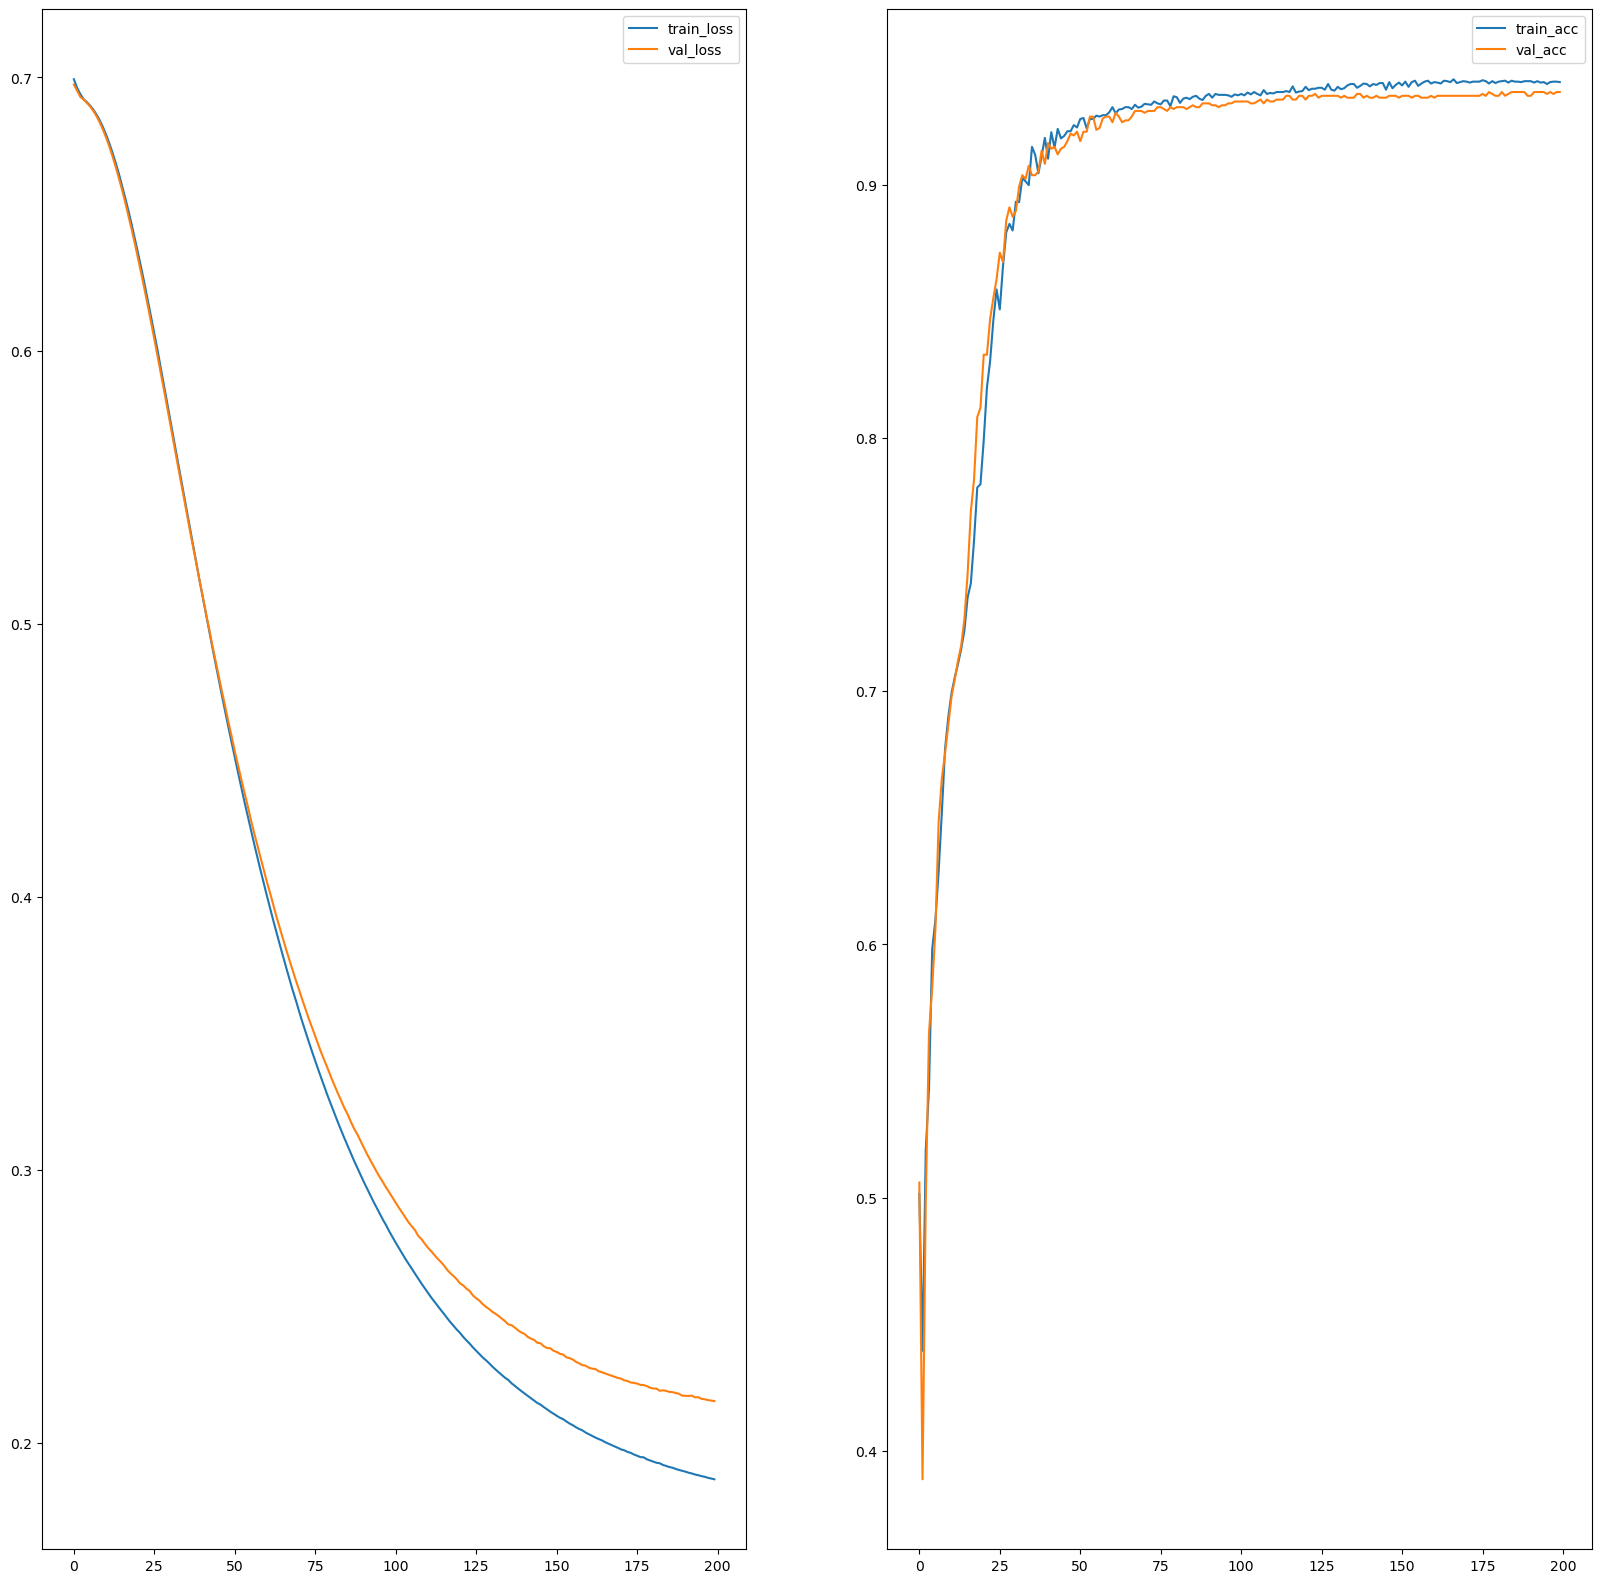

In [26]:
# construcción de un data.frame
df_train=pd.DataFrame(history.history)
df_train['epochs']=history.epoch

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.plot(df_train['epochs'], df_train['loss'], label='train_loss')
ax1.plot(df_train['epochs'], df_train['val_loss'], label='val_loss')

ax2.plot(df_train['epochs'], df_train['accuracy'], label='train_acc')
ax2.plot(df_train['epochs'], df_train['val_accuracy'], label='val_acc')

ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
plt.show()


In [27]:
# Predicción para la muestra de test
predictions_proba = model.predict(X_test)
predictions_class = np.where(predictions_proba >0.5, 1, 0)



<AxesSubplot:ylabel='Count'>

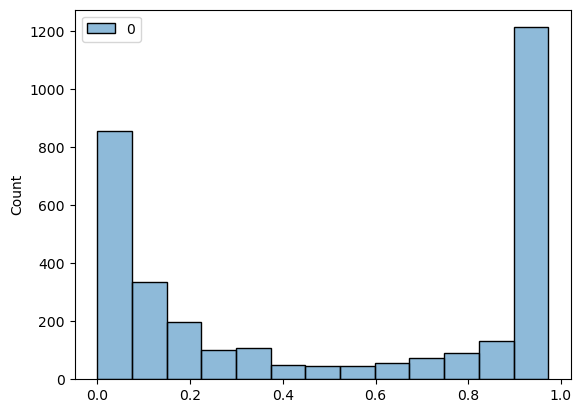

In [31]:
# Histograma de la predicción
sns.histplot(data=predictions_proba)

In [28]:
# Performance
print('accuracy:', np.round(accuracy_score(y_test, predictions_class),5))
print('precision:', np.round(precision_score(y_test, predictions_class),5))
print('recall:', np.round(recall_score(y_test, predictions_class),5))

# auc 
fpr, tpr, _ = roc_curve(y_test, predictions_proba)  # obtención de las tasas de falsos y verdaderos positivos
print('auc:', np.round(auc(fpr, tpr),5))

accuracy: 0.93545
precision: 0.95176
recall: 0.91935
auc: 0.97557


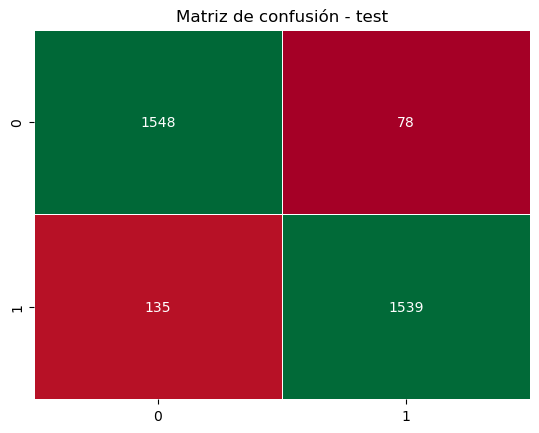

In [29]:
# matriz de confusión
sns.heatmap(confusion_matrix(y_test, predictions_class), 
            cmap="RdYlGn", linewidths=.5, 
            annot = True,  fmt='.0f', cbar=False) 
plt.title('Matriz de confusión - test')
plt.show()



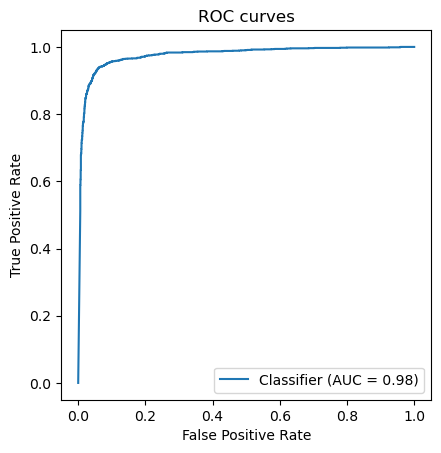

In [30]:

RocCurveDisplay.from_predictions(y_true=y_test,y_pred=predictions_proba)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

# Prueba 1. 
## Reducir muestra de datos 


<AxesSubplot:xlabel='x', ylabel='y'>

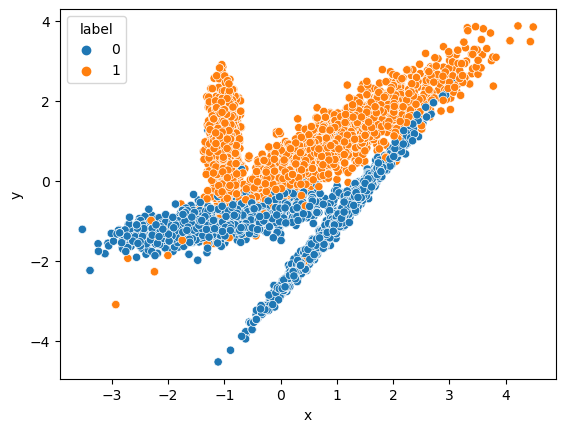

In [41]:
df_80=df.sample(frac=0.8,replace=True,random_state=seed)
sns.scatterplot(x=df_80['x'],y=df_80['y'],hue=df_80['label'])

In [42]:
scaler = preprocessing.MinMaxScaler()
d=scaler.fit_transform(df_80)
scaled_df_80=pd.DataFrame(d,columns=df_80.columns)
scaled_df_80.head()

,x,y,label
0,0.498408,0.330016,0.0
1,0.629195,0.518009,0.0
2,0.277231,0.705698,1.0
3,0.341823,0.597824,1.0
4,0.300219,0.471979,1.0


In [43]:
# Split train and test
X_80=scaled_df_80[['x','y']]
y_80=scaled_df_80['label']

X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X_80, y_80, test_size=0.33, random_state=seed)

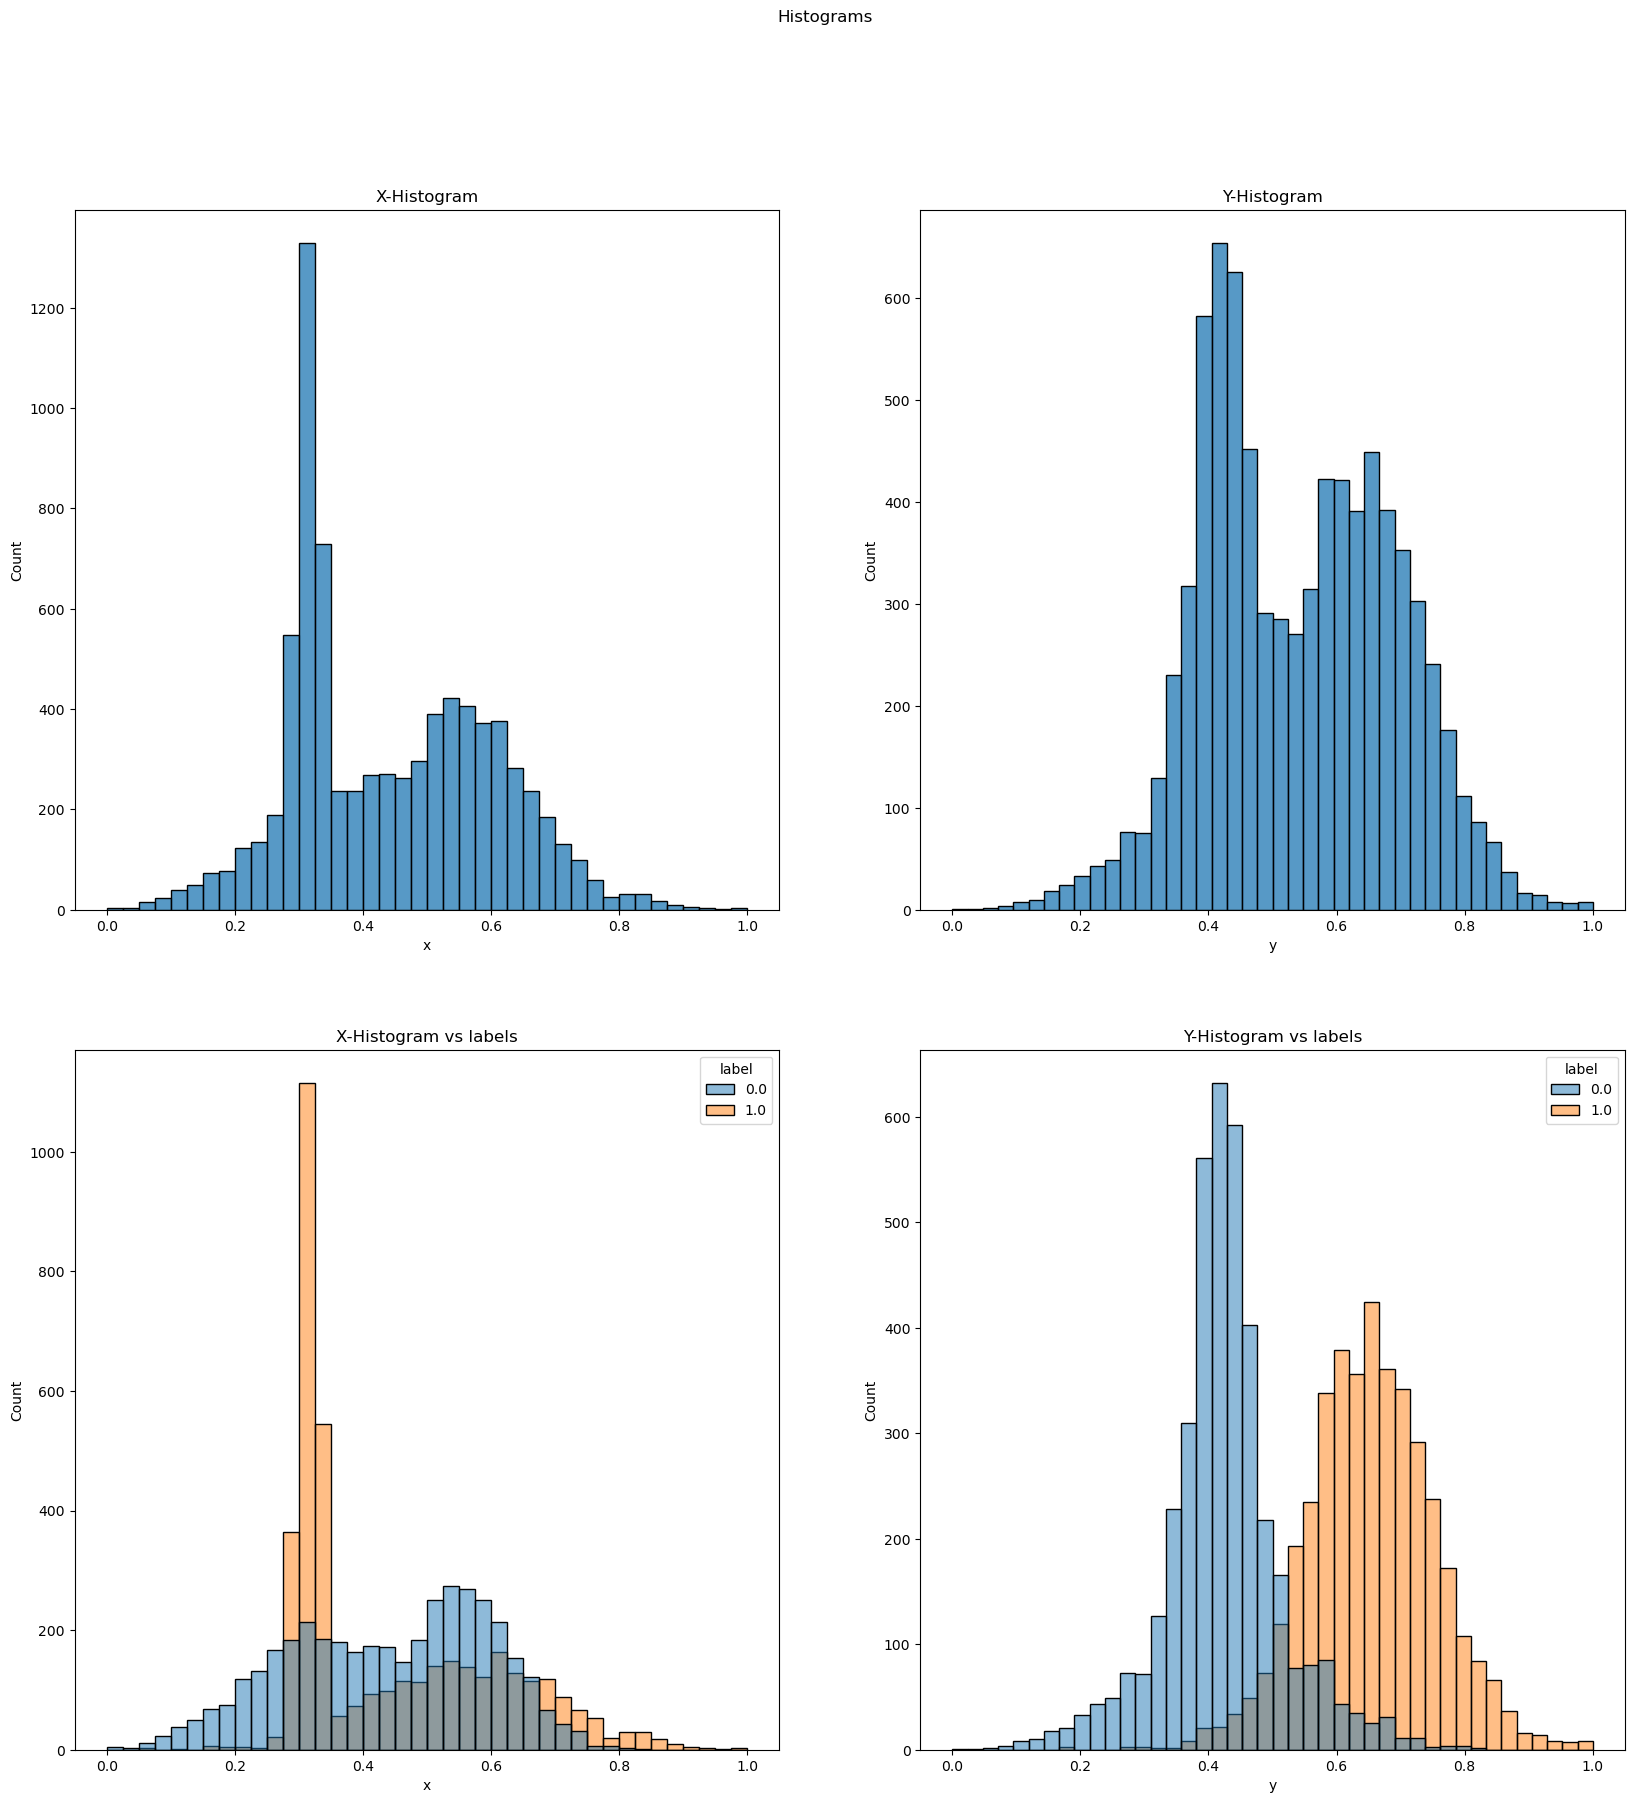

In [44]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20,20))
sns.histplot(ax=axes[0,0],data=scaled_df_80,x='x')
axes[0,0].set_title ("X-Histogram")

sns.histplot(ax=axes[0,1],data=scaled_df_80,x='y')
axes[0,1].set_title ("Y-Histogram")

sns.histplot(ax=axes[1,0],data=scaled_df_80,x='x',hue='label')
axes[1,0].set_title ("X-Histogram vs labels")

sns.histplot(ax=axes[1,1],data=scaled_df_80,x='y',hue='label')
axes[1,1].set_title ("Y-Histogram vs labels")

plt.suptitle ("Histograms")
plt.show()

In [60]:
model_80=tf.keras.models.load_model('inicial.h5')

AttributeError: 'str' object has no attribute 'decode'